Start with each college, compared to national, for all years: t-test for proportions\
Each college, compared to its local, for all years: t-test for all proportions


In [62]:
%pip install scipy
%pip install statsmodels

from scipy.stats import ttest_rel, ttest_ind, spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
jobs = pd.read_csv('jobs_manual_output.csv')
colleges = pd.read_csv('colleges.csv')

colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

def calculate_national_proportions(jobs_df, year):
    major_rows = jobs_df[(jobs_df['Year'] == year) & (jobs_df['Occupation Group'] == 'major')].copy()
    national_total = major_rows['Total Employment'].sum()
    major_rows['Proportions'] = (major_rows['Total Employment'] / national_total) * 100
    return major_rows

def sum_employment_by_major(job_df, college, college_year, job_year, area):
    input_sum = job_df['Proportions'].sum()
    if not (99 <= input_sum <= 101):
        print(f"College: {college}, Job Year: {job_year}, College Year: {college_year}, Area: {area}")
        print(f"Warning: Input proportions sum to {input_sum:.2f}%")
    employment_df = pd.DataFrame(columns=['Major Field', 'Total Employment', 'Proportions'])
    for index, row in job_df.iterrows():
        major = row['Major Field']
        employment = row['Total Employment']
        proportions = row['Proportions']
        
        if major in employment_df['Major Field'].values:
            employment_df.loc[employment_df['Major Field'] == major, 'Total Employment'] += employment
            employment_df.loc[employment_df['Major Field'] == major, 'Proportions'] += proportions
        else:
            employment_df.loc[len(employment_df)] = {'Major Field': major, 'Total Employment': employment, 'Proportions': proportions}
    
    total = employment_df['Proportions'].sum()
    if not (99 <= total <= 101):
        print(f"Warning: Output proportions sum to {total:.2f}%")
    return employment_df

def compare_job_to_college(jobs, colleges, college, college_year, job_year, area):
    if area == 'all':
        jobs_df = jobs[jobs['Year'] == job_year]
        jobs_df = calculate_national_proportions(jobs_df, job_year)
    else:
        jobs_df = jobs[jobs['Occupation Group'] == 'major']
        jobs_df = jobs_df[(jobs_df['Year'] == job_year) & (jobs_df['Area'] == area)]
        jobs_df = jobs_df[(jobs_df['Occupation Group'] == 'major')].copy()
        area_total = jobs_df['Total Employment'].sum()
        jobs_df['Proportions'] = (jobs_df['Total Employment'] / area_total) * 100

    college_df = colleges[(colleges['Year'] == college_year) & (colleges['College'] == college)]
    job_employment_df = sum_employment_by_major(jobs_df, college, college_year, job_year, area)
    combined_df = pd.merge(college_df, job_employment_df, on='Major Field', how='outer')
    combined_df['Total Employment'] = combined_df['Total Employment'].fillna(0)
    combined_df['Proportions'] = combined_df['Proportions'].fillna(0)
    combined_df['Bachelors'] = combined_df['Bachelors'].fillna(0)
    combined_df['Year'] = combined_df['Year'].fillna(college_df['Year'].iloc[0])
    combined_df['College'] = combined_df['College'].fillna(college_df['College'].iloc[0])
    _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
    return p, combined_df
    
college_to_area_map = {
    'ucsd': "San Diego-Carlsbad, CA",
    'asu': "Winston-Salem, NC",
    'colgate': "Utica-Rome, NY",
    'dartmouth': "West Central-Southwest New Hampshire nonmetropolitan area",
    'caltech': "Los Angeles-Long Beach-Anaheim, CA",
    'george': "Washington-Arlington-Alexandria, DC-VA-MD-WV Metropolitan Division",
    'umich': "Ann Arbor, MI",
    'wsu': "Spokane-Spokane Valley, WA"
}

combined = pd.DataFrame()
p_value_df = pd.DataFrame(columns=['College', 'College Year', 'Job Year', 'Area', 'P-Value'])
for key in college_to_area_map.keys():
    for year in range(2014, 2023):
        for area in ['all', college_to_area_map[key]]:
            for i in range(-6, 1):
                if year + i in range(2014, 2023):
                    college_year = year
                    job_year = year + i
                    # uncomment the next line to run
                    p_value, combined_df = compare_job_to_college(jobs, colleges, key, college_year, job_year, area)
                    combined = pd.concat([combined, combined_df])
                    p_value_df.loc[len(p_value_df)] = {'College': key, 'College Year': college_year, 'Job Year': job_year, 'Area': area, 'P-Value': p_value}

print(p_value_df)
    

    College  College Year  Job Year                        Area  P-Value
0      ucsd          2014      2014                         all      1.0
1      ucsd          2014      2014      San Diego-Carlsbad, CA      1.0
2      ucsd          2015      2014                         all      1.0
3      ucsd          2015      2015                         all      1.0
4      ucsd          2015      2014      San Diego-Carlsbad, CA      1.0
..      ...           ...       ...                         ...      ...
667     wsu          2022      2018  Spokane-Spokane Valley, WA      1.0
668     wsu          2022      2019  Spokane-Spokane Valley, WA      1.0
669     wsu          2022      2020  Spokane-Spokane Valley, WA      1.0
670     wsu          2022      2021  Spokane-Spokane Valley, WA      1.0
671     wsu          2022      2022  Spokane-Spokane Valley, WA      1.0

[672 rows x 5 columns]


In [82]:
jobs = pd.read_csv('jobs_manual_output.csv')
colleges = pd.read_csv('colleges.csv')

colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

def calculate_national_proportions(jobs_df, year):
    national_df = jobs_df[(jobs_df['Year'] == year) & (jobs_df['Occupation Group'] == 'total')].copy()
    national_total = national_df['Total Employment'].sum()
    major_rows = jobs_df[(jobs_df['Year'] == year) & (jobs_df['Occupation Group'] == 'major')].copy()
    major_rows['Proportions'] = (major_rows['Total Employment'] / national_total) * 100
    return major_rows

def sum_employment_by_major(job_df, college, college_year, job_year, area):
    input_sum = job_df['Proportions'].sum()
    if not (99 <= input_sum <= 101):
        print(f"College: {college}, Job Year: {job_year}, College Year: {college_year}, Area: {area}")
        print(f"Warning: Input proportions sum to {input_sum:.2f}%")
    employment_df = pd.DataFrame(columns=['Major Field', 'Total Employment', 'Proportions'])
    for index, row in job_df.iterrows():
        major = row['Major Field']
        employment = row['Total Employment']
        proportions = row['Proportions']
        
        if major in employment_df['Major Field'].values:
            employment_df.loc[employment_df['Major Field'] == major, 'Total Employment'] += employment
            employment_df.loc[employment_df['Major Field'] == major, 'Proportions'] += proportions
        else:
            employment_df.loc[len(employment_df)] = {'Major Field': major, 'Total Employment': employment, 'Proportions': proportions}
    
    total = employment_df['Proportions'].sum()
    if not (99 <= total <= 101):
        print(f"Warning: Output proportions sum to {total:.2f}%")
    return employment_df

def compare_job_to_college(jobs, colleges, college, college_year, job_year, area):
    if area == 'all':
        jobs_df = jobs[jobs['Year'] == job_year]
        jobs_df = calculate_national_proportions(jobs_df, job_year)
    else:
        jobs_df = jobs[jobs['Occupation Group'] == 'major']
        jobs_df = jobs_df[(jobs_df['Year'] == job_year) & (jobs_df['Area'] == area)]

    college_df = colleges[(colleges['Year'] == college_year) & (colleges['College'] == college)]
    job_employment_df = sum_employment_by_major(jobs_df, college, college_year, job_year, area)
    combined_df = pd.merge(college_df, job_employment_df, on='Major Field', how='outer')
    combined_df['Total Employment'] = combined_df['Total Employment'].fillna(0)
    combined_df['Proportions'] = combined_df['Proportions'].fillna(0)
    combined_df['Bachelors'] = combined_df['Bachelors'].fillna(0)
    combined_df['Year'] = combined_df['Year'].fillna(college_df['Year'].iloc[0])
    combined_df['College'] = combined_df['College'].fillna(college_df['College'].iloc[0])
    _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
    return p, combined_df
    
college_to_area_map = {
    'ucsd': "San Diego-Carlsbad, CA",
    'asu': "Winston-Salem, NC",
    'colgate': "Utica-Rome, NY",
    'dartmouth': "West Central-Southwest New Hampshire nonmetropolitan area",
    'caltech': "Los Angeles-Long Beach-Anaheim, CA",
    'george': "Washington-Arlington-Alexandria, DC-VA-MD-WV Metropolitan Division",
    'umich': "Ann Arbor, MI",
    'wsu': "Spokane-Spokane Valley, WA"
}

combined = pd.DataFrame()
p_value_df = pd.DataFrame(columns=['College', 'College Year', 'Job Year', 'Area', 'P-Value'])
for key in college_to_area_map.keys():
    for year in range(2014, 2023):
        for area in ['all', college_to_area_map[key]]:
            for i in range(-6, 1):
                if year + i in range(2014, 2023):
                    college_year = year
                    job_year = year + i
                    # uncomment the next line to run
                    p_value, combined_df = compare_job_to_college(jobs, colleges, key, college_year, job_year, area)
                    combined = pd.concat([combined, combined_df])
                    p_value_df.loc[len(p_value_df)] = {'College': key, 'College Year': college_year, 'Job Year': job_year, 'Area': area, 'P-Value': p_value}

print(p_value_df)
    

College: dartmouth, Job Year: 2015, College Year: 2015, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2016, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2017, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2018, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2019, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2020, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: dartmouth, Job Year: 2015, College Year: 2021, Area: West Central-Southwest New Hampshire nonmetropolitan area
College: umich, Job Year: 2016, College Year: 2016, Area: Ann Arbor, MI
College: umich, Job Year: 2016, College Year: 2017, Area: Ann Arbor, MI
College: umich, 

In [83]:
# write to csv so other people don't have to run 24 mins of code
p_value_df.to_csv('p_value.csv', index=False)
combined_df.to_csv('combined.csv', index=False)

# print out significant p-values
for index, row in p_value_df.iterrows():
    if row['P-Value'] < 0.05:
        print(f"School: {row['College']}, College Year: {row['College Year']}, Job Year: {row['Job Year']}, Area: {row['Area']}, P-Value: {row['P-Value']}")
significant_p_values = p_value_df[p_value_df['P-Value'] < 0.05]
p_value_df = p_value_df.sort_values(by='P-Value')
print(p_value_df.head())

       College  College Year  Job Year  \
302  dartmouth          2020      2015   
315  dartmouth          2021      2015   
278  dartmouth          2018      2015   
289  dartmouth          2019      2015   
269  dartmouth          2017      2015   

                                                  Area   P-Value  
302  West Central-Southwest New Hampshire nonmetrop...  0.430754  
315  West Central-Southwest New Hampshire nonmetrop...  0.431507  
278  West Central-Southwest New Hampshire nonmetrop...  0.433449  
289  West Central-Southwest New Hampshire nonmetrop...  0.434056  
269  West Central-Southwest New Hampshire nonmetrop...  0.436664  


In [85]:
num_plots = len(significant_p_values)
rows = (num_plots + 2) // 3 
cols = min(3, num_plots)

plt.figure(figsize=(15, 5*rows))

for i, row in enumerate(significant_p_values.iterrows()):
    row = row[1]  # Get the row data
    college = row['College']
    college_year = row['College Year']
    job_year = row['Job Year']
    area = row['Area']
    p_value = row['P-Value']
    specific_df = combined_df[combined_df['College'] == college & combined_df['College Year'] == college_year & combined_df['Area'] == area & combined_df['Job Year'] == job_year]
    proportion = specific_df['Proportions']
    bachelors = specific_df['Bachelors']
    
    print(spearmanr(row['Proportions'], row['Bachelors']))
    plt.subplot(rows, cols, i+1)
    
    plt.scatter(row['Proportions'], row['Bachelors'], alpha=0.6)
    
    plt.xlabel('Proportions')
    plt.ylabel('Bachelors')
    plt.title(f'{college} ({college_year}-{job_year})\np={p_value:.3f}')
    plt.grid(True)

plt.tight_layout()
plt.show()


<Figure size 1500x0 with 0 Axes>


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     Year College  CIP Code          Major Field  Bachelors
727  2019  george      11.0     Computer science       2.17
728  2019  george      16.0           Humanities       4.06
729  2019  george      23.0           Humanities       4.15
730  2019  george      24.0      Social sciences       1.57
731  2019  george      26.0  Biological sciences       4.15
732  2019  george      27.0          Mathematics       2.81
733  2019  george      30.0      Social sciences       6.73
734  2019  george      38.0           Humanities       1.24
735  2019  george      40.0    Physical sciences       1.29
736  2019  george      42.0      Social sciences       4.29
737  2019  george      45.0      Social sciences      32.73
738  2019  george       5.0      Social sciences       1.84
739  2019  george      50.0

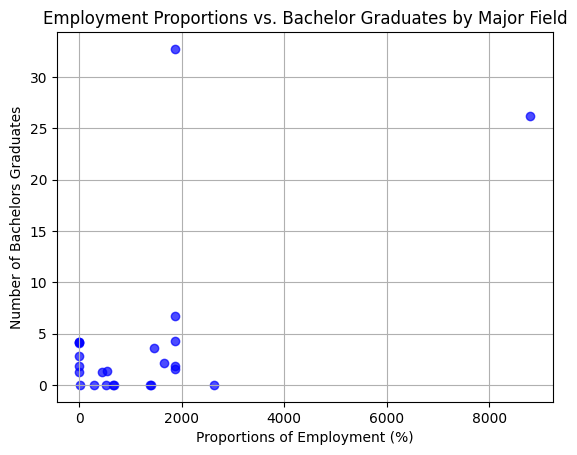

In [58]:
%pip install matplotlib
import matplotlib.pyplot as plt

jobs = pd.read_csv('jobs.csv')
colleges = pd.read_csv('colleges.csv')
colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

george_data = colleges[(colleges['Year'] == 2019) & (colleges['College'] == 'george')]
print(george_data)
job_2016 = jobs[(jobs['Year'] == 2016)]
job_2016 = job_2016[job_2016['Occupation Group'] == 'major']
job_2016 = job_2016[job_2016['Area'] == 'Washington-Arlington-Alexandria, DC-VA-MD-WV Metropolitan Division']
print(job_2016)
job_2016_employment = sum_employment_by_major(job_2016)
job_2016_employment['Proportions'] *= 100
print(job_2016_employment['Proportions'].sum())
combined_df = pd.merge(job_2016_employment, george_data, on='Major Field', how='outer')
combined_df['Total Employment'] = combined_df['Total Employment'].fillna(0)
combined_df['Proportions'] = combined_df['Proportions'].fillna(0)
combined_df['Bachelors'] = combined_df['Bachelors'].fillna(0)
combined_df['Year'] = combined_df['Year'].fillna(george_data['Year'].iloc[0])
combined_df['College'] = combined_df['College'].fillna(george_data['College'].iloc[0])
print(combined_df)
print(spearmanr(combined_df['Proportions'], combined_df['Bachelors']))

plt.scatter(combined_df['Proportions'], combined_df['Bachelors'], color='blue', alpha=0.7)
plt.xlabel('Proportions of Employment (%)')
plt.ylabel('Number of Bachelors Graduates')
plt.title('Employment Proportions vs. Bachelor Graduates by Major Field')
plt.grid(True)
plt.show()

In [57]:
# Bonferroni Correction is most likely not needed because we can manually adjust for false positives
for college in p_value_df['College'].unique():
    p_value_list = p_value_df[p_value_df['College'] == college]
    rejected, p_adjusted, _, _ = multipletests(p_value_list['P-Value'], alpha=0.05, method='holm')
    print(f"{college}: {rejected}")
    for i in range(len(rejected)):
        if rejected[i]:
            print(f"School: {p_value_list.iloc[i]['College']}, College Year: {p_value_list.iloc[i]['College Year']}, Job Year: {p_value_list.iloc[i]['Job Year']}, Area: {p_value_list.iloc[i]['Area']}, P-Value: {p_value_list.iloc[i]['P-Value']}")
rejected, p_adjusted, _, _ = multipletests(p_value_df['P-Value'], alpha=0.05, method='holm')
print(rejected)

george: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
dartmouth: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False 

In [24]:
jobs = pd.read_csv('jobs.csv')
colleges = pd.read_csv('colleges.csv')

colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

jobs = jobs[jobs['Occupation Group'] != ""]
jobs = jobs[jobs['Year'] == 2020]
jobs['Proportions'] = jobs.apply(calculate_proportion, axis=1)
job_df = jobs[jobs['Occupation Group'] == 'major']
print(job_df.head(20))

job_df = sum_employment_by_major(job_df)
job_df['Proportions'] *= 100
total_proportion = job_df['Proportions'].sum()
print(f"Total Proportion: {total_proportion}")
print(job_df.head(20))

college_df = colleges[(colleges['Year'] == 2018) & (colleges['College'] == "dartmouth")]
total_bachelors = college_df['Bachelors'].sum()
print(f"Total Bachelors: {total_bachelors}")
print(college_df.head(20))

merged_df = pd.merge(college_df, job_df, on='Major Field', how='outer')

merged_df['Total Employment'] = merged_df['Total Employment'].fillna(0)
merged_df['Proportions'] = merged_df['Proportions'].fillna(0)
merged_df['Bachelors'] = merged_df['Bachelors'].fillna(0)
merged_df['Year'] = merged_df['Year'].fillna(college_df['Year'].iloc[0])
merged_df['College'] = merged_df['College'].fillna(college_df['College'].iloc[0])

print(merged_df)

compare_job_to_college(jobs, colleges, 'dartmouth', 2018, 2020, "West Central-Southwest New Hampshire nonmetropolitan area")

       Year           Area Occupation Group  \
70317  2020  Ann Arbor, MI            major   
70345  2020  Ann Arbor, MI            major   
70368  2020  Ann Arbor, MI            major   
70384  2020  Ann Arbor, MI            major   
70404  2020  Ann Arbor, MI            major   
70425  2020  Ann Arbor, MI            major   
70439  2020  Ann Arbor, MI            major   
70443  2020  Ann Arbor, MI            major   
70481  2020  Ann Arbor, MI            major   
70500  2020  Ann Arbor, MI            major   
70543  2020  Ann Arbor, MI            major   
70557  2020  Ann Arbor, MI            major   
70568  2020  Ann Arbor, MI            major   
70582  2020  Ann Arbor, MI            major   
70589  2020  Ann Arbor, MI            major   
70599  2020  Ann Arbor, MI            major   
70616  2020  Ann Arbor, MI            major   
70655  2020  Ann Arbor, MI            major   
70656  2020  Ann Arbor, MI            major   
70669  2020  Ann Arbor, MI            major   

            

np.float64(0.043429449126644294)

In [42]:
def verify_proportions(jobs_df):
    # Group by Year and Area
    for (year, area), group in jobs_df.groupby(['Year', 'Area']):
        # Get the total employment for this year/area
        total_row = group[group['Occupation Group'] == '']
        if len(total_row) == 0:
            continue
            
        total_employment = total_row['Total Employment'].iloc[0]
        
        # Get all major occupation rows
        major_rows = group[group['Occupation Group'] == 'major']
        
        # Calculate and sum their proportions
        proportions_sum = (major_rows['Total Employment'].sum() / total_employment) * 100
        
        # Check if sum is approximately 100
        if not (99.9 <= proportions_sum <= 100.1):
            print(f"Year: {year}, Area: {area}")
            print(f"Proportion sum: {proportions_sum:.2f}%")
            print("------------------------")

# Run verification
jobs = pd.read_csv('jobs.csv')
verify_proportions(jobs)